> ## Setup

In [15]:
# imports
import pandas as pd
import seaborn as sns
import folium
from ipyleaflet import GeoJSON, Map, Marker
import geopandas as gpd
import geojson
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib import colors
import numpy as np
import openrouteservice
from pmdarima import auto_arima 

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings

Run Download Script

In [ ]:
%run ../scripts/download.py

Run Data Preprocessing

In [ ]:
warnings.filterwarnings('ignore')
%run ../notebooks/Data_preprocessing.ipynb

Convert property address to coorinates

In [ ]:
%run ../scripts/'address_coordinate_converter.py'

# Utilizing Open Route Service API, takes about 30 minutes to complete

Find the distance to the nearest train station

In [ ]:
%run ../scripts/'property_train_euclidean_distance.py'

> ## Question 1 (Important Features for Predicting Rental Price)

In our classification model, the four most important features for predicting rental prices are as follows:


1. Bedrooms: The number of bedrooms is a significant determinant of rental prices, as it directly correlates with the capacity and comfort of the living space. 
Properties with more bedrooms typically cater to larger households, making them more desirable and, consequently, commanding higher rental rates.


2. Postcode: The postcode serves as an indicator of the property's location, which significantly influences rental values. 
Areas with desirable postcodes often offer better access to amenities, transportation, and schools, 
contributing to higher demand and increased rental prices.


3. Bathrooms: The quantity of bathrooms is another crucial factor impacting rental pricing.
A higher number of bathrooms enhances convenience for tenants, 
especially in larger households, and is often seen as a desirable feature that can justify a premium in rental costs.


4. Parking Spaces: The availability of parking spaces is a vital consideration in many regions, 
particularly in urban settings where parking can be scarce. 
Properties that offer designated parking tend to attract tenants who prioritize this convenience, 
thereby increasing the potential rental value.

In [ ]:
property_df = pd.read_csv("../data/curated/processed property_w_distance.csv")
property_df['log_min_train_dist'] = np.log1p(property_df['min_train_dist'])
corr_columns = [
    "price (AUD per week)", "bedrooms", "bathrooms", "parkings", "log_min_train_dist"
]

sns.heatmap(property_df[corr_columns].corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/pearson_corr.png', bbox_inches='tight')
plt.show()
# no strong relationship bewteen price and log_min_train_dist


With Spearman's correlation, bedroom number is still the most significant.\
The correlation is almost zero between distance to the closest train station and rental price.

In [ ]:
sns.heatmap(property_df[corr_columns].corr(method='spearman'))
plt.title('Spearman Correlation Metric')
plt.savefig('../plots/spearmans_corr.png', bbox_inches='tight')
plt.show()

# still no strong relationship bewteen price and log_min_train_dist

By using Anova, there are sufficent evidences to the effect of suburb and property type on rental price.
Suburb have a 0.000172 p-vlaue, and property type have the p-value equal to 1.878596e-41.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Rename the 'price (AUD per week)' column
property_df = property_df.rename(columns={'price (AUD per week)': 'price_per_week'})
# Rename the 'property type' column
property_df = property_df.rename(columns={'property type': 'property_type'})

# test effect of suburb on rental price
model_suburb = ols('price_per_week ~ C(suburb)', data=property_df).fit()

anova_suburb = sm.stats.anova_lm(model_suburb, typ=2)
print(anova_suburb)

# there is a statistically significant effect of suburb on rental price

# test effect of property type on rental price
model_type = ols('price_per_week ~ C(property_type)', data=property_df).fit()

anova_type = sm.stats.anova_lm(model_type, typ=2)
print(anova_type)

# there is a statistically significant effect of property type on rental price


We developed classification models to predict rental price categories. Our best-performing models were Random Forest and Gradient Boosting, both achieving an accuracy of 77%. This high accuracy rate supports the reliability of our feature importance analysis.

The classification models provided additional insights into feature importance. They confirmed that the number of bedrooms and bathrooms are indeed crucial factors.

In [ ]:
# Load the data
data = pd.read_csv('../data/curated/processed property_w_distance.csv')


# Clean and preprocess the data
data['price'] = data['price (AUD per week)']
data['log_rental_price'] = np.log(data['price'])
data['bedrooms'] = data['bedrooms'].fillna(0)

# Create price categories for classification
data['price_category'] = pd.cut(data['price per bedroom'], bins=[0, 300, 600, 900, np.inf],
                                labels=['Low', 'Medium', 'High', 'Very High'])

# Split features and target
X = data[['bedrooms', 'bathrooms', 'parkings', 'property type', 'suburb', 'min_train_dist']]
y_regression = data['log_rental_price']
y_classification = data['price_category']

# Split the data
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_regression, y_classification, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['bedrooms', 'bathrooms', 'parkings', 'min_train_dist']
categorical_features = ['property type', 'suburb']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Regression Model
reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)

# Classification Model
class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

class_model.fit(X_train, y_class_train)
y_class_pred = class_model.predict(X_test)

# Visualization 1: Regression Model - Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression Model: Predicted vs Actual Prices')
plt.tight_layout()
plt.show()

# Visualization 2: Regression Model - Residuals Plot
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_reg_pred.min(), xmax=y_reg_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Regression Model: Residuals Plot')
plt.tight_layout()
plt.show()

# Visualization 3: Classification Model - Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Model: Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualization 4: Classification Model - Feature Importance
feature_importance = class_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 class_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Classification Model: Top 10 Feature Importance')
plt.tight_layout()
plt.show()

# Print model performance metrics
print("Regression Model Performance:")
print(f"Mean Squared Error: {mean_squared_error(y_reg_test, y_reg_pred):.2f}")
print(f"R-squared Score: {r2_score(y_reg_test, y_reg_pred):.2f}")

print("\nClassification Model Performance:")
print(f"Accuracy: {class_model.score(X_test, y_class_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))

In [8]:
# Initialize and train new models
simple_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

simple_class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

complex_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

complex_class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Fit the models
simple_reg_model.fit(X_train, y_reg_train)
complex_reg_model.fit(X_train, y_reg_train)
simple_class_model.fit(X_train, y_class_train)
complex_class_model.fit(X_train, y_class_train)

# Predictions
y_simple_reg_pred = simple_reg_model.predict(X_test)
y_complex_reg_pred = complex_reg_model.predict(X_test)
y_simple_class_pred = simple_class_model.predict(X_test)
y_complex_class_pred = complex_class_model.predict(X_test)

# Evaluation
# Regression Model Performance (Simple and Complex)
simple_reg_mse = mean_squared_error(y_reg_test, y_simple_reg_pred)
simple_reg_r2 = r2_score(y_reg_test, y_simple_reg_pred)

complex_reg_mse = mean_squared_error(y_reg_test, y_complex_reg_pred)
complex_reg_r2 = r2_score(y_reg_test, y_complex_reg_pred)

# Classification Model Performance (Simple and Complex)
simple_class_report = classification_report(y_class_test, y_simple_class_pred, output_dict=True)
complex_class_report = classification_report(y_class_test, y_complex_class_pred, output_dict=True)

# Prepare the comparison table for regression
regression_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Gradient Boosting'],
    'MSE': [mean_squared_error(y_reg_test, y_reg_pred), simple_reg_mse, complex_reg_mse],
    'R-squared': [r2_score(y_reg_test, y_reg_pred), simple_reg_r2, complex_reg_r2]
})

# Prepare the comparison table for classification
classification_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [class_model.score(X_test, y_class_test), simple_class_model.score(X_test, y_class_test), complex_class_model.score(X_test, y_class_test)],
    'Precision (Weighted Avg)': [simple_class_report['weighted avg']['precision'], simple_class_report['weighted avg']['precision'], complex_class_report['weighted avg']['precision']],
    'Recall (Weighted Avg)': [simple_class_report['weighted avg']['recall'], simple_class_report['weighted avg']['recall'], complex_class_report['weighted avg']['recall']]
})




In [ ]:
# Plotting the regression model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="MSE", data=regression_comparison, hue="Model")
plt.title("Regression Model Comparison (MSE)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R-squared", data=regression_comparison, hue="Model")
plt.title("Regression Model Comparison (R-squared)")
plt.tight_layout()
plt.show()

# Plotting the classification model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Accuracy)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Precision (Weighted Avg)", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Precision - Weighted Avg)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Recall (Weighted Avg)", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Recall - Weighted Avg)")
plt.tight_layout()
plt.show()


> ## Question 2 (Predict Suburb Growth)

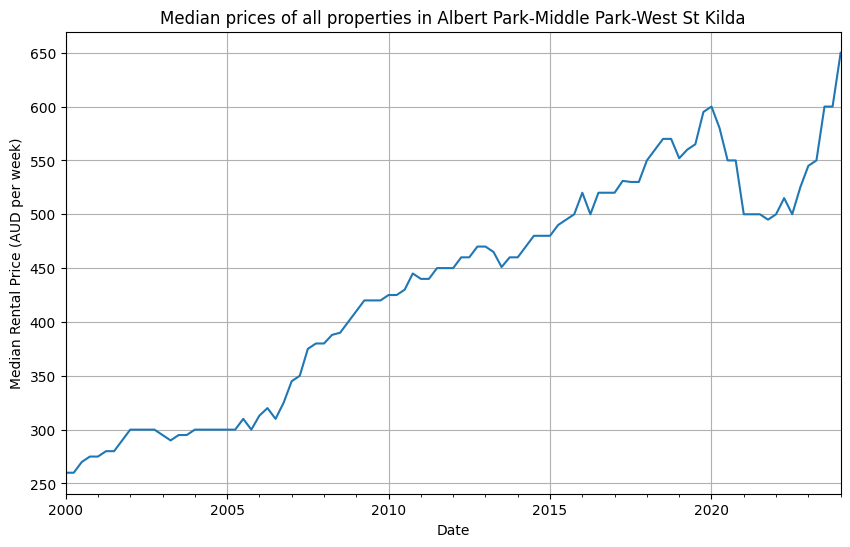

/home/lqp303203/GitHub/MAST30034_Python/project-2-group-real-estate-industry-project-27/scripts/arima model.py:58: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  predict_dates = pd.date_range(start=dataframe_list[i].columns[-1], periods=15, freq='Q')
/home/lqp303203/GitHub/MAST30034_Python/project-2-group-real-estate-industry-project-27/scripts/arima model.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_df[suburb] = predictions
/home/lqp303203/GitHub/MAST30034_Python/project-2-group-real-estate-industry-project-27/scripts/arima model.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [ ]:
# Fitting the ARIMA models to the historical data
%run ../models/'ARIMA model.ipynb'

After fitting the ARIMA model to the historical rental price and predict the future prices, we have output the predictions dataframe as below. 

Using these predictions, we can calculate the annual growth rate and output the top 10 suburbs with the highest growth rate for each property type.

We will also evaluate our ARIMA model using time-series cross-validation.

In [ ]:
# Read the historical and predictions data
historical_df = pd.read_csv('../data/curated/historical without postcode/cleaned All properties.csv')
predict_df = pd.read_csv('../data/analysis/future prices by suburb/predict all properties.csv')

In [ ]:
predict_df

In [19]:
# Convert date in df to datetime format
historical_df.set_index('suburb', inplace=True)
predict_df.set_index('index', inplace=True)
historical_df.columns = pd.to_datetime(historical_df.columns, format='%b %Y')
predict_df.index = pd.to_datetime(predict_df.index, dayfirst=True)

We will visualise the rental price predictions of one of the suburbs:

In [ ]:
# Get the first suburb name
first_suburb = historical_df.index[0]

# Plot historical prices for the first suburb
plt.plot(historical_df.columns, historical_df.loc[first_suburb], label=f'Historical {first_suburb}', color='blue')

# Plot predicted prices for the same suburb
plt.plot(predict_df.index, predict_df[first_suburb], label=f'Predicted {first_suburb}', color='orange', linestyle='--')

# Format the x-axis
ax = plt.gca()  
ax.xaxis.set_major_locator(mdates.AutoDateLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

plt.title(f'Median Rental Prices for {first_suburb}')
plt.ylabel('Median Rental Price (AUD per week)')

plt.legend()

plt.tight_layout()
plt.show()


This plot is saved under ..plots/future predictions of one suburb.png

The trend in the predicted values is similar to the trend of rental prices pre-COVID, suggesting that our model is not significantly affected by the data drift during COVID.

Using the calculated growth rate, we can see the top 10 suburbs with highest predicted growth rate

In [ ]:
folder_path = '../data/analysis/future prices by suburb/'
growth_filename = ['growth 1 bedroom flat.csv', 'growth 2 bedroom flat.csv', 'growth 3 bedroom flat.csv',
                    'growth 2 bedroom house.csv', 'growth 3 bedroom house.csv', 'growth 4 bedroom house.csv',
                    'growth all properties.csv']

property_types = ['one bed flat', 'two bed flat', 'three bed flat', 'two bed house', 'three bed house',
                 'four bed house', 'all properties']

for i in range(len(growth_filename)):
    file_path = folder_path + growth_filename[i]
    growth_df = pd.read_csv(file_path)
    top_10 = growth_df.nlargest(10, 'growth rate')
    property_type = property_types[i]
    print(f"Top 10 suburbs with highest predicted growth rate for {property_type}")
    print(top_10)

We will evaluate the performance of ARIMA models by calculating the time-series cross-validation's RMSE for the all properties type.

In [ ]:
# TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for suburb in historical_df.index:  
    rental_prices = historical_df.loc[suburb].dropna() 

    # Perform TimeSeriesSplit cross-validation
    for train_index, test_index in tscv.split(rental_prices):
        y_train, y_test = rental_prices[train_index], rental_prices[test_index]

        # Fit ARIMA model on the training set
        model = auto_arima(y_train, seasonal=False, stepwise=True)

        # Forecast the same number of periods as the test set
        forecast = model.predict(n_periods=len(y_test))

        # Calculate RMSE for this fold
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        rmse_scores.append(rmse)

In [ ]:
# Print average RMSE across all splits
print(f'Average RMSE: ${np.mean(rmse_scores):.2f} per week')

This is the average RMSE calculated from time-series cross-validation on the historical data, therefore it is influenced by the deviations from predictions during COVID-19. 

We would expect smaller RMSE for our predictions if no future data drift occurs, or similar RMSE if there is an occurence of some data drift of the scale of COVID-19.

> ## Question 3 (Liveability and Afforfability)

Liveability as a feature of a region is difficult to quantify, however with the use of the Social Indicators dataset from the City of Melbourne public population census data we can compose an aggregated statistic which captures information about aspects of liveability such as: health, quality of life, engagement with learning, and how safe people feel. The drawback to this dataset is the fairly limited coverage across our suburbs of interest, and less than total coverage of the City of Melbourne postcodes. This leads to some data sparsity, however we can still draw some meaningful conclusions from the analysis of this data.

$Liveability = w_h \cdot \frac{1}{n} \sum_{i=1}^{n}h_i + w_q \cdot \frac{1}{n} \sum_{i=1}^{n}q_i + w_l \cdot \frac{1}{n} \sum_{i=1}^{n}l_i + w_s \cdot \frac{1}{n} \sum_{i=1}^{n}s_i$

$w_h$ = weighting for health scores, $h_i$ = ith health score

$w_q$ = weighting for quality of life scores, $q_i$ = ith quality of life score

$w_l$ = weighting for learning scores, $l_i$ = ith learning score

$w_s$ = weighting for safety scores, $s_i$ = ith safety score


In [22]:
# load data
liveability_df = pd.read_csv("../data/curated/liveability_scores.csv").set_index("postcode")
liveability_melted_df = liveability_df.reset_index().melt(id_vars=['suburb', 'postcode'])

def CalculateWeightedLiveabilityScore(dataframe, weights = [1,1,1,1,1,1,1]):
    return sum([dataframe[dataframe.columns[x]] * weights[x] for x in range(0, len(dataframe.columns) - 2)])

In [ ]:
# liveability scores and individual metrics for suburbs with available social indicator data from highest score to lowest
liveability_df.sort_values(by=["score"], ascending=False)

From the above table we can see Flemington has the highest score given equal weightings for the three metrics

In [ ]:
# plot liveability scores across surveyed suburbs
c_plot = sns.catplot(data = liveability_melted_df, x = "suburb", y = "value", hue = "variable")
c_plot.set_xticklabels(rotation = 45, ha='right')
c_plot.set(title="City of Melbourne Suburbs: Liveability Score and Composit Metrics")

> ## Geospatial Visualisations

Using Geojson postcode boundaries from the City of Melbourne public data repository we can plot some of the features and statistics we've calculated over the course of the analysis on maps as geospatial visualisations. Some notable features to look at in this format are median rental prices, and liveability scores.

In [69]:
median_postcode_df = pd.read_csv("../data/raw/median_price_per_postcode.csv")
historical_price_df = pd.read_csv("../data/raw/cleaned all properties.csv")

with open("../data/landing/geodata/suburbs.geojson", "r") as f:
    geojson_suburbs = geojson.load(f)

# define colouring function for median rental price
def median_rental_colour(feature):
    postcode = feature["properties"]["mccid_int"]
    df_median_price = median_postcode_df[median_postcode_df["postcode"] == int(postcode)]
    if df_median_price.empty:
        return {"color":"white", "fillColor":"black"}   
    median_price_max = max(median_postcode_df["median_1_bedroom_Apartment / Unit / Flat"])
    median_price_min = min(median_postcode_df["median_1_bedroom_Apartment / Unit / Flat"])
    price_col = (df_median_price["median_1_bedroom_Apartment / Unit / Flat"] - median_price_min) / (median_price_max - median_price_min)
    hex_col = colors.to_hex(cm.YlOrRd(float(max(price_col)))) 
    return {"color":"white", "fillColor":hex_col}

# define colouring function for liveability score
def liveability_colour(feature):
    postcode = int(feature["properties"]["mccid_int"])
    if not postcode in liveability_df.index:
        return {"color":"white", "fillColor":"black"}
    score_col = liveability_df.loc[postcode].score
    hex_col = colors.to_hex(cm.RdYlGn(score_col/7.0)) 
    return {"color":"white", "fillColor":hex_col}

# construct map given a colouring
def map(map_func):
    map_melb = Map(center=(-37.8082, 144.96332), zoom=12)
    geo_json = GeoJSON(  
        data=geojson_suburbs,  
        style={  
            "opacity": 1,  
            "dashArray": "9",  
            "fillOpacity": 0.5,  
            "weight": 1,  
        },
        hover_style={"color": "white", "dashArray": "0", "fillOpacity": 0.8},
        style_callback = map_func
    ) 
    map_melb.add_layer(geo_json)
    
    return map_melb

Map of The City of Melbourne with postcodes shaded by median rent price for 1 bedroom appartments:

In [ ]:
# display median rental price map
map(median_rental_colour)

We can see that in the CBD the weekly rent price of 1 bedroom appartments is significantly higher than areas further towards the edges of the city suggesting that this is likely to be a less affordable location for students to rent in if they're living alone.

Map of The City of Melbourne with postcodes shaded by liveability score:

In [ ]:
# display liveabiltiy map
map(liveability_colour)

In addition to being unaffordable to rent, the CBD also has the lowest liveability score of all City of Melbourne postcodes whereas Flemington is both more affordable and has a high liveability score. Flemington isn't particularly close to any universities though so Carlton or East Melbourne may be more useful recommendations.

> ## Limitations and Assumptions

- Data Acquisition: 
    - Rate Limiting with services like Openrouteservice makes transport based distance calculations time consuming so we had to compromise with euclidean distance.
    - Social Indicator dataset restricted to a small number of surveyed postcodes
- Model Limitations: 
    - Potential inaccuracies due to unanticipated socio-economic changes, like policy shifts affecting rental markets. 



In [ ]:
# liveability postcodes surveyed only span a small range of suburbs:
liveability_df.sort_values(by=["score"], ascending=False)[["suburb", "score"]]

> ## Rental Data Dashboard App

To run the dashboard app run the following command:

`shiny run --reload --launch-browser ../scripts/app.py`